# Gesture Recognition Project

**To Run on JarvisLabs.ai**

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
#from scipy.misc import imread, imresize
#from imageio import imread #using instead of imread from scipy.misc
#from scipy.misc import imresize
from skimage.io import imread #using instead of imread from scipy.misc
from skimage.transform import resize #use resize instead of imresize
import datetime
import os
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.regularizers import l2
from keras import optimizers
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
BASE_DIRECTORY = '/datasets/Project_data'
TRAIN_DIR = '{0}/train'.format(BASE_DIRECTORY)
VAL_DIR = '{0}/val'.format(BASE_DIRECTORY)
MODEL_SAVE_DIR = 'MODELS'

total_frames = 30

print('Training data: ', TRAIN_DIR)
print('Validation data: ', VAL_DIR)

Training data:  /datasets/Project_data/train
Validation data:  /datasets/Project_data/val


In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In [4]:
#train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
#val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())

train_doc = np.random.permutation(open('{0}/train.csv'.format(BASE_DIRECTORY)).readlines())
val_doc = np.random.permutation(open('{0}/val.csv'.format(BASE_DIRECTORY)).readlines())

batch_size = 20 #experiment with the batch size
print("Training data:" , len(train_doc))
print("Validation data:", len(val_doc))

Training data: 663
Validation data: 100


In [5]:
classes = ['Thumbs up', 'Thumbs down','Left swipe', 'Right swipe', 'Stop']
print(classes)
num_classes = len(classes)
print(num_classes)

['Thumbs up', 'Thumbs down', 'Left swipe', 'Right swipe', 'Stop']
5


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

#### Generator & Support Functions

In [74]:
import cv2
def process_batch(source_path, folders_list, batch, batch_size, num_frames, img_idx,  height, width, channels = 3): #num_frames=20,
    #num_frames = len(img_idx)
    batch_data   = np.zeros((batch_size, num_frames, height, width, channels)) # 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output           

    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ folders_list[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            image = imread(source_path+'/'+ folders_list[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes                    
            h, w, c = image.shape
            image = resize(image, (height, width), anti_aliasing=True)
            
            if(channels == 3):
                batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
            else:
                batch_data[folder,idx,:,:,0] =  cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        batch_labels[folder, int(folders_list[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

def OLD___process_batch(source_path, folders_list, batch, batch_size, img_idx, height=120, width=120):
    num_images = len(img_idx)
    batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output

    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ folders_list[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            image = imread(source_path+'/'+ folders_list[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape
            #and the conv3D will throw error if the inputs in a batch have different shapes
            h, w, c = image.shape
            if w == 160:
                image = image[: 20:140, :] #Crop Horizontal edges to make it a square image
            image = resize(image, (height, width), anti_aliasing=True)

            batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
            batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image

        batch_labels[folder, int(folders_list[folder + (batch*batch_size)].strip().split(';')[2])] = 1

    yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [31]:
def gesture_generator(source_path, folder_list, batch_size, num_images = 20, height=120, width=120, channels=3):
    img_idx = len(np.round(np.linspace(0,total_frames-1, num_images)).astype(int))
    while True:
        randomized_folders_list = np.random.permutation(folder_list)
        num_batches = len(randomized_folders_list)//batch_size # calculate the number of batches
        img_idx = np.round(np.linspace(0,total_frames-1, num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            for X, y in process_batch(source_path, randomized_folders_list, batch, batch_size, num_images, img_idx, height, width, channels):
                yield X, y
        
        remaining_batch_size = len(folder_list)%batch_size
        if(remaining_batch_size):
            for X, y in process_batch(source_path, randomized_folders_list, batch, remaining_batch_size, num_images, img_idx, height, width, channels):
                yield X, y

def gesture_generator(source_path, folder_list, batch_size, img_idx, height=120, width=120):
    #total_frames = 30
    #num_images = len(img_idx)
    while True:
        number_of_batches = len(folder_list)//batch_size # calculate the number of batches
        randomized_folders_list = np.random.permutation(folder_list)

        for batch in range(number_of_batches): # we iterate over the number of batches
            for batch_data, batch_labels in process_batch(source_path, randomized_folders_list, batch, batch_size, img_idx, height, width):
                yield batch_data, batch_labels

            # Remaining (would be < than the batch size) = total - (number_of_batches * batch_size)
            remaining_batch_size = len(folder_list) - (number_of_batches * batch_size)
            if (remaining_batch_size > 0):
                for batch_data, batch_labels in process_batch(source_path, randomized_folders_list, batch, remaining_batch_size, img_idx, height, width):
                    yield batch_data, batch_labels

In [8]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [9]:
def visualize_outputs(fit_data, epoch):
    acc = fit_data.history['categorical_accuracy']
    val_acc = fit_data.history['val_categorical_accuracy']

    loss = fit_data.history['loss']
    val_loss = fit_data.history['val_loss']

    epochs_range = range(epoch)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [10]:
t = np.random.permutation(train_doc)
nb = len(t)//batch_size
range(nb)

range(0, 33)

## Prepare a Model
### 1. Create a Conv3D + RNN (GRU)

### Model-01

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers
from tensorflow.python.keras.utils.data_utils import Sequence

In [32]:
height = 120 # image width
width = 120 # image height

num_images = 20
batch_size = 20 #experiment with the batch size
#img_idx = len(np.round(np.linspace(0,total_frames-1,num_images)).astype(int))

num_epochs = 15
LrPlateau_patience = 2
LrPlateau_mode = 'auto'
LrPlateau_factor = 0.1
LrPlateau_fmin_lr = 0.00001

In [33]:
def prepare_conv3d_model(channels=3):
    model = Sequential()
    model.add(Conv3D(32, (3,3, 3), padding='same', input_shape=(num_images, height, width, channels)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.20))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [34]:
def model_callbacks(curr_dt_time, save_folder_name):
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    save_file_path = save_folder_name + '/' + model_name + '/'
    if not os.path.exists(save_file_path):
        os.makedirs(save_file_path, mode=0o666)
    filepath = save_file_path + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    #LR = # write the REducelronplateau code here
    #LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, fmin_lr=0.00001, verbose=1)
    #return [checkpoint, LR]
    return checkpoint

In [35]:
def get_steps_info(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    return steps_per_epoch, validation_steps

In [36]:
model_01 = prepare_conv3d_model()
optimizer = keras.optimizers.adam_v2.Adam()
model_01.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_01.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 20, 120, 120, 32)  2624      
                                                                 
 activation_5 (Activation)   (None, 20, 120, 120, 32)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 10, 60, 60, 32)   0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 10, 60, 60, 64)    55360     
                                                                 
 activation_6 (Activation)   (None, 10, 60, 60, 64)    0         
                                                                 
 batch_normalization_1 (Batc  (None, 10, 60, 60, 64)   256       
 hNormalization)                                      

In [37]:
height = 120 # image width
width = 120 # image height

num_images = 20
batch_size = 20 #experiment with the batch size
img_idx = len(np.round(np.linspace(0,total_frames-1,num_images)).astype(int))

num_epochs = 15
LrPlateau_patience = 2
LrPlateau_mode = 'auto'
LrPlateau_factor = 0.1
LrPlateau_fmin_lr = 0.00001

In [38]:
curr_dt_time = datetime.datetime.now()
LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=LrPlateau_factor,
                       patience=LrPlateau_patience,
                       fmin_lr=LrPlateau_fmin_lr, verbose=1)

callbacks_list = [model_callbacks(curr_dt_time, MODEL_SAVE_DIR), LR]
steps_per_epoch, validation_steps = get_steps_info(len(train_doc), len(val_doc), batch_size)

In [39]:
print('Epochs', num_epochs)
print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)

Epochs 15
steps_per_epoch 34
validation_steps 5


In [40]:
training_data_gen = gesture_generator(source_path=TRAIN_DIR, folder_list=train_doc, batch_size=batch_size, num_images=20, height=height, width=width)
validation_data_gen = gesture_generator(source_path=VAL_DIR, folder_list=val_doc, batch_size=batch_size, num_images=20, height=height, width=width)

In [41]:
#fit_generator is deprecated.. using model.fit with generator objects...

history = model_01.fit(x=training_data_gen, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                       callbacks=callbacks_list, validation_data=validation_data_gen,
                       validation_steps=validation_steps)

Epoch 1/15


2023-10-01 16:24:45.501897: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2023-10-01 16:24:49.817502: I tensorflow/stream_executor/cuda/cuda_blas.cc:1792] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


34/34 [==============================] - ETA: 0s - loss: 3.8520 - categorical_accuracy: 0.3137
Epoch 00001: val_loss improved from inf to 1.58935, saving model to MODELS/model_init_2023-10-0116_24_36.808265/model-00001-3.85200-0.31373-1.58935-0.24000.h5
34/34 [==============================] - 128s 4s/step - loss: 3.8520 - categorical_accuracy: 0.3137 - val_loss: 1.5893 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.1666 - categorical_accuracy: 0.5294
Epoch 00002: val_loss improved from 1.58935 to 1.57039, saving model to MODELS/model_init_2023-10-0116_24_36.808265/model-00002-1.16660-0.52941-1.57039-0.20000.h5
34/34 [==============================] - 105s 3s/step - loss: 1.1666 - categorical_accuracy: 0.5294 - val_loss: 1.5704 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 0.8654 - categorical_accuracy: 0.6621
Epoch 00003: val_loss improved from 1

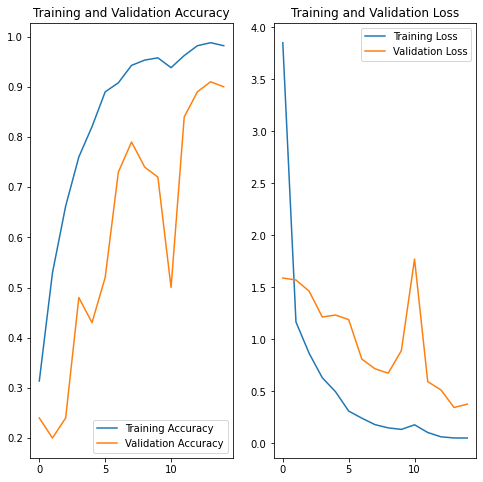

In [42]:
visualize_outputs(history, epoch=num_epochs)

#### Observations

- The model is able to achieve only 98% accuracy. The validation loss is ~90%. 
- The diff. is not huge. however the loss doesn't get a flatline.. 
- The model is trained for 15 epochs. We can try to increase the epochs count to check for better accuracy metrics.
- The model shows no signs of overfitting as the difference between the train and validation loss is very less.
- Total params: 3,856,069
Trainable params: 3,855,941
Non-trainable params: 128)

### Model-02:

- Increasig the epochs to 20
- Increasing the batch size from 20 -> 30
- Adjust the Learning Rate Factor to a smaller value... 

In [50]:
def prepare_conv3d_model_02():
    model = Sequential()
    model.add(Conv3D(32, (3,3,3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(128, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))

    model.add(Conv3D(128, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.20))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [51]:
height = 120 # image width
width = 120 # image height

num_images = 20
batch_size = 30 #experiment with the batch size
img_idx = len(np.round(np.linspace(0,total_frames-1,num_images)).astype(int))

num_epochs = 20

LrPlateau_patience = 2
LrPlateau_mode = 'auto'
LrPlateau_factor = 0.1
LrPlateau_fmin_lr = 0.0001


In [52]:
curr_dt_time = datetime.datetime.now()
LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=LrPlateau_factor,
                       patience=LrPlateau_patience,
                       fmin_lr=LrPlateau_fmin_lr, verbose=1)

callbacks_list = [model_callbacks(curr_dt_time, MODEL_SAVE_DIR), LR]
steps_per_epoch, validation_steps = get_steps_info(len(train_doc), len(val_doc), batch_size)

In [53]:
print('Epochs', num_epochs)
print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)

Epochs 20
steps_per_epoch 23
validation_steps 4


In [54]:
model_02 = prepare_conv3d_model_02()
optimizer = optimizers.adam_v2.Adam()
model_02.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_02.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 20, 120, 120, 32)  2624      
                                                                 
 activation_10 (Activation)  (None, 20, 120, 120, 32)  0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 10, 60, 60, 32)   0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 10, 60, 60, 64)    55360     
                                                                 
 activation_11 (Activation)  (None, 10, 60, 60, 64)    0         
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 5, 30, 30, 64)    0         
 3D)                                                  

In [55]:
training_data_gen = gesture_generator(TRAIN_DIR, train_doc, batch_size, img_idx, height, width)
validation_data_gen = gesture_generator(VAL_DIR, val_doc, batch_size, img_idx, height, width)

In [56]:
#fit_generator is deprecated.. using model.fit with generator objects...

history_02 = model_02.fit(x=training_data_gen, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                       callbacks=callbacks_list, validation_data=validation_data_gen,
                       validation_steps=validation_steps)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.3608 - categorical_accuracy: 0.3906
Epoch 00001: val_loss improved from inf to 1.51263, saving model to MODELS/model_init_2023-10-0117_15_58.407071/model-00001-1.36077-0.39065-1.51263-0.25000.h5
23/23 [==============================] - 105s 5s/step - loss: 1.3608 - categorical_accuracy: 0.3906 - val_loss: 1.5126 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.0056 - categorical_accuracy: 0.5732
Epoch 00002: val_loss did not improve from 1.51263
23/23 [==============================] - 104s 5s/step - loss: 1.0056 - categorical_accuracy: 0.5732 - val_loss: 1.5459 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.7678 - categorical_accuracy: 0.6953
Epoch 00003: val_loss improved from 1.51263 to 1.34116, saving model to MODELS/model_init_2023-10-0117_15_58.407071/model-00003-0.76783-0.

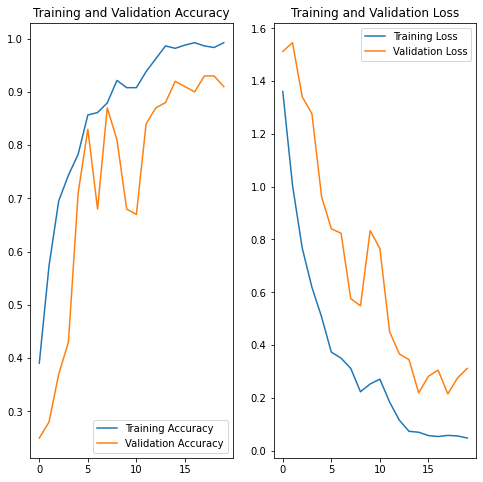

In [57]:
visualize_outputs(history_02, epoch=num_epochs)

### Observations

- The Loss graph is not stablized and also the there is no improvement in the accuracy. 
- Total params: 981,189 Trainable params: 980,933 Non-trainable params: 256

### MODEL-03

- Experiment with increasing the Dense layers.
- Adjust Learning Rate Plateau factor.

In [59]:
def prepare_conv3d_model_03():
    model = Sequential()
    model.add(Conv3D(32, (3,3,3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(128, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))

    model.add(Conv3D(128, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dense(128))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.20))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [60]:
height = 120 # image width
width = 120 # image height

batch_size = 20 #experiment with the batch size
img_idx = len(np.round(np.linspace(0,total_frames-1,num_images)).astype(int))
num_epochs = 20

LrPlateau_patience = 2
LrPlateau_mode = 'auto'
LrPlateau_factor = 0.1
LrPlateau_fmin_lr = 0.0001


In [61]:
curr_dt_time = datetime.datetime.now()
LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=LrPlateau_factor,
                       patience=LrPlateau_patience,
                       fmin_lr=LrPlateau_fmin_lr, verbose=1)

callbacks_list = [model_callbacks(curr_dt_time, MODEL_SAVE_DIR), LR]
steps_per_epoch, validation_steps = get_steps_info(len(train_doc), len(val_doc), batch_size)

In [62]:
print('Epochs', num_epochs)
print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)

Epochs 20
steps_per_epoch 34
validation_steps 5


In [63]:
model_03 = prepare_conv3d_model_03()
optimizer = optimizers.adam_v2.Adam()
model_03.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_03.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_11 (Conv3D)          (None, 20, 120, 120, 32)  2624      
                                                                 
 activation_17 (Activation)  (None, 20, 120, 120, 32)  0         
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 10, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_12 (Conv3D)          (None, 10, 60, 60, 64)    55360     
                                                                 
 activation_18 (Activation)  (None, 10, 60, 60, 64)    0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 5, 30, 30, 64)    0         
 g3D)                                                 

In [64]:
training_data_gen = gesture_generator(TRAIN_DIR, train_doc, batch_size, img_idx, height, width)
validation_data_gen = gesture_generator(VAL_DIR, val_doc, batch_size, img_idx, height, width)

In [65]:
#fit_generator is deprecated.. using model.fit with generator objects...

history_03 = model_03.fit(x=training_data_gen, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                       callbacks=callbacks_list, validation_data=validation_data_gen,
                       validation_steps=validation_steps)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6181 - categorical_accuracy: 0.2172
Epoch 00001: val_loss improved from inf to 1.60914, saving model to MODELS/model_init_2023-10-0117_50_41.071095/model-00001-1.61809-0.21719-1.60914-0.21000.h5
34/34 [==============================] - 105s 3s/step - loss: 1.6181 - categorical_accuracy: 0.2172 - val_loss: 1.6091 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.5387 - categorical_accuracy: 0.2745
Epoch 00002: val_loss improved from 1.60914 to 1.40639, saving model to MODELS/model_init_2023-10-0117_50_41.071095/model-00002-1.53865-0.27451-1.40639-0.37000.h5
34/34 [==============================] - 104s 3s/step - loss: 1.5387 - categorical_accuracy: 0.2745 - val_loss: 1.4064 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.3179 - categorical_accuracy: 0.3771
Epoch 00003: val_loss impr

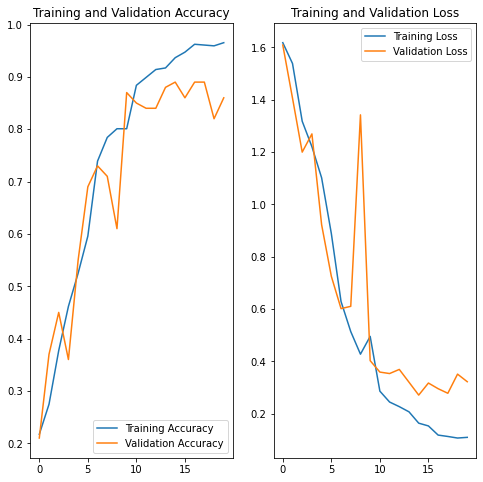

In [66]:
visualize_outputs(history_03, epoch=num_epochs)

### Model-04

- Experimenting the same model with a reduced image size to 100x100

In [67]:
height = 100 # image width
width = 100 # image height

batch_size = 20 #experiment with the batch size

num_epochs = 20
LrPlateau_patience = 2
LrPlateau_mode = 'auto'
LrPlateau_factor = 0.1
LrPlateau_fmin_lr = 0.0001


In [68]:
curr_dt_time = datetime.datetime.now()
LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=LrPlateau_factor,
                       patience=LrPlateau_patience,
                       fmin_lr=LrPlateau_fmin_lr, verbose=1)

callbacks_list = [model_callbacks(curr_dt_time, MODEL_SAVE_DIR), LR]
steps_per_epoch, validation_steps = get_steps_info(len(train_doc), len(val_doc), batch_size)

In [69]:
print('Epochs', num_epochs)
print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)

Epochs 20
steps_per_epoch 34
validation_steps 5


In [70]:
model_04 = prepare_conv3d_model_03()
optimizer = optimizers.adam_v2.Adam()
model_04.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_04.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 20, 100, 100, 32)  2624      
                                                                 
 activation_24 (Activation)  (None, 20, 100, 100, 32)  0         
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 10, 50, 50, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 10, 50, 50, 64)    55360     
                                                                 
 activation_25 (Activation)  (None, 10, 50, 50, 64)    0         
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 5, 25, 25, 64)    0         
 g3D)                                                 

In [71]:
training_data_gen = gesture_generator(TRAIN_DIR, train_doc, batch_size, img_idx, height, width)
validation_data_gen = gesture_generator(VAL_DIR, val_doc, batch_size, img_idx, height, width)

In [72]:
#fit_generator is deprecated.. using model.fit with generator objects...

history_04 = model_04.fit(x=training_data_gen, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                       callbacks=callbacks_list, validation_data=validation_data_gen,
                       validation_steps=validation_steps)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6784 - categorical_accuracy: 0.1961
Epoch 00001: val_loss improved from inf to 1.61099, saving model to MODELS/model_init_2023-10-0118_25_29.766805/model-00001-1.67844-0.19608-1.61099-0.16000.h5
34/34 [==============================] - 104s 3s/step - loss: 1.6784 - categorical_accuracy: 0.1961 - val_loss: 1.6110 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.6110 - categorical_accuracy: 0.1719
Epoch 00002: val_loss improved from 1.61099 to 1.60968, saving model to MODELS/model_init_2023-10-0118_25_29.766805/model-00002-1.61099-0.17195-1.60968-0.20000.h5
34/34 [==============================] - 103s 3s/step - loss: 1.6110 - categorical_accuracy: 0.1719 - val_loss: 1.6097 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.6061 - categorical_accuracy: 0.1976
Epoch 00003: val_loss impr

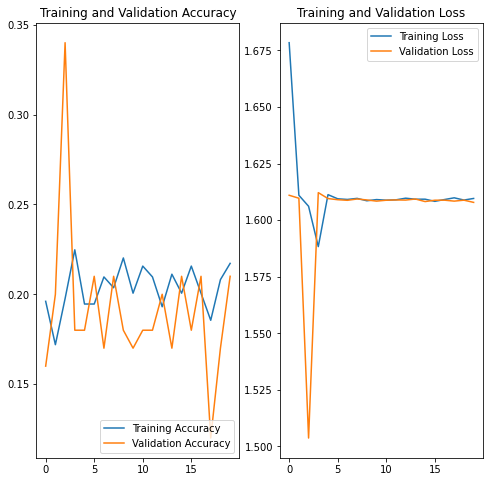

In [73]:
visualize_outputs(history_04, epoch=num_epochs)

#### Observations

- No improvement in the accuracy levels. 
- Loss has also increased. No improvement in reducing the image size. 
- Total params: 1,169,093 Trainable params: 1,169,093

### Model-05
- The problem is to identify the gesture and has no relation with the colors of the image. Hence, trying out to grayscale the image so as to reduce the layers and parameters. 

import cv2

def process_batch_grayscale(source_path, folders_list, batch, batch_size, img_idx, height=120, width=120):
    print(img_idx)
    num_images = len(img_idx)
    batch_data   = np.zeros((batch_size, num_images, height, width, 1)) # 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output

    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ folders_list[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            image = imread(source_path+'/'+ folders_list[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape
            #and the conv3D will throw error if the inputs in a batch have different shapes
            h, w, c = image.shape
            if w == 160:
                image = image[: 20:140, :] #Crop Horizontal edges to make it a square image
            image = resize(image, (height, width), anti_aliasing=True)
            
            batch_data[folder,idx,:,:,0] = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            #batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
            #batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
            #batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image

        batch_labels[folder, int(folders_list[folder + (batch*batch_size)].strip().split(';')[2])] = 1

    yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


def gesture_generator_grayscale(source_path, folder_list, batch_size, img_idx, height=120, width=120):
    #total_frames = 30
    #num_images = len(img_idx)
    print(type(img_idx), img_idx)
    while True:
        number_of_batches = len(folder_list)//batch_size # calculate the number of batches
        randomized_folders_list = np.random.permutation(folder_list)

        for batch in range(number_of_batches): # we iterate over the number of batches
            for batch_data, batch_labels in process_batch(source_path, randomized_folders_list, batch, batch_size, img_idx, height, width):
                yield batch_data, batch_labels

            # Remaining (would be < than the batch size) = total - (number_of_batches * batch_size)
            remaining_batch_size = len(folder_list) - (number_of_batches * batch_size)
            if (remaining_batch_size > 0):
                for batch_data, batch_labels in process_batch(source_path, randomized_folders_list, batch, remaining_batch_size, img_idx, height, width):
                    yield batch_data, batch_labels

In [80]:
def prepare_conv3d_grayscale_model_05(num_classes, color_channels = 3):
    model = Sequential()
    model.add(Conv3D(32, (3,3,3), padding='same', input_shape=(num_images, height, width, color_channels)))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(64, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Conv3D(128, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(3, 3, 2), padding='same'))

    model.add(Conv3D(256, (3,3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dense(128))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.20))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [81]:
height = 120 # image width
width = 120 # image height

batch_size = 30 #experiment with the batch size

num_epochs = 20
LrPlateau_patience = 2
LrPlateau_mode = 'auto'
LrPlateau_factor = 0.2
LrPlateau_fmin_lr = 0.0001


In [82]:

curr_dt_time = datetime.datetime.now()
LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=LrPlateau_factor,
                       patience=LrPlateau_patience,
                       fmin_lr=LrPlateau_fmin_lr, verbose=1)

callbacks_list = [model_callbacks(curr_dt_time, MODEL_SAVE_DIR), LR]
steps_per_epoch, validation_steps = get_steps_info(len(train_doc), len(val_doc), batch_size)


In [83]:
print('Epochs', num_epochs)
print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)

Epochs 20
steps_per_epoch 23
validation_steps 4


In [84]:
model_05 = prepare_conv3d_grayscale_model_05(num_classes, 1)
optimizer = optimizers.adam_v2.Adam()
model_05.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_05.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 20, 120, 120, 32)  896       
                                                                 
 activation_31 (Activation)  (None, 20, 120, 120, 32)  0         
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 10, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_22 (Conv3D)          (None, 10, 60, 60, 64)    55360     
                                                                 
 activation_32 (Activation)  (None, 10, 60, 60, 64)    0         
                                                                 
 max_pooling3d_22 (MaxPoolin  (None, 5, 30, 30, 64)    0         
 g3D)                                                 

In [85]:
training_data_gen = gesture_generator(TRAIN_DIR, train_doc, batch_size, img_idx, height, width, channels=1)
validation_data_gen = gesture_generator(VAL_DIR, val_doc, batch_size, img_idx, height, width, channels=1)

In [86]:
#fit_generator is deprecated.. using model.fit with generator objects...
history_05 = model_05.fit(x=training_data_gen, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                       callbacks=callbacks_list, validation_data=validation_data_gen,
                       validation_steps=validation_steps)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 4.0005 - categorical_accuracy: 0.1991
Epoch 00001: val_loss improved from inf to 1.59697, saving model to MODELS/model_init_2023-10-0119_06_19.253625/model-00001-4.00055-0.19910-1.59697-0.21000.h5
23/23 [==============================] - 99s 4s/step - loss: 4.0005 - categorical_accuracy: 0.1991 - val_loss: 1.5970 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.5847 - categorical_accuracy: 0.2519
Epoch 00002: val_loss improved from 1.59697 to 1.49737, saving model to MODELS/model_init_2023-10-0119_06_19.253625/model-00002-1.58466-0.25189-1.49737-0.26000.h5
23/23 [==============================] - 98s 4s/step - loss: 1.5847 - categorical_accuracy: 0.2519 - val_loss: 1.4974 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.4983 - categorical_accuracy: 0.2926
Epoch 00003: val_loss improv

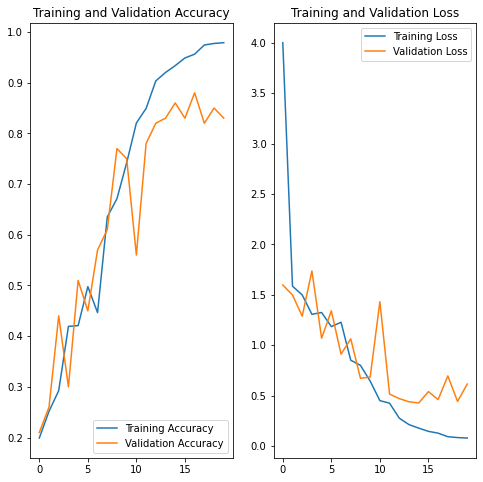

In [87]:
visualize_outputs(history_05, epoch=num_epochs)

### MODEL 6
- With Reduced Batch Size

In [ ]:
height = 120 # image width
width = 120 # image height

batch_size = 10 #experiment with the batch size
img_idx = np.arange(5, 26, 2) #create a list of image numbers you want to use for a particular video
num_epochs = 20
LrPlateau_patience = 2
LrPlateau_mode = 'auto'
LrPlateau_factor = 0.2
LrPlateau_fmin_lr = 0.1


In [ ]:

curr_dt_time = datetime.datetime.now()
LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=LrPlateau_factor,
                       patience=LrPlateau_patience,
                       fmin_lr=LrPlateau_fmin_lr, verbose=1)

callbacks_list = [model_callbacks(curr_dt_time, MODEL_SAVE_DIR), LR]
steps_per_epoch, validation_steps = get_steps_info(len(train_doc), len(val_doc), batch_size)


In [ ]:
print('Epochs', num_epochs)
print('steps_per_epoch', steps_per_epoch)
print('validation_steps', validation_steps)

In [ ]:
training_data_gen = gesture_generator_grayscale(TRAIN_DIR, train_doc, batch_size, img_idx, height, width)
validation_data_gen = gesture_generator_grayscale(VAL_DIR, val_doc, batch_size, img_idx, height, width)

In [ ]:
model_06 = prepare_conv3d_grayscale_model_05(num_classes)
optimizer = optimizers.adam_v2.Adam()
model_06.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_06.summary()

In [ ]:
#fit_generator is deprecated.. using model.fit with generator objects...
history_06 = model_06.fit(x=training_data_gen, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                       callbacks=callbacks_list, validation_data=validation_data_gen,
                       validation_steps=validation_steps)

In [ ]:
visualize_outputs(history_06, epoch=num_epochs)

In [ ]:
#TODO::: CNN-RNN